# Make Notebook Run in Watson Studio

In [1]:
# The code was removed by Watson Studio for sharing.

In [2]:
# START CODE BLOCK
# cos2file - takes an object from Cloud Object Storage and writes it to file on container file system.
# Uses the IBM project_lib library.
# See https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/project-lib-python.html
# Arguments:
# p: project object defined in project token
# data_path: the directory to write the file
# filename: name of the file in COS

import os
def cos2file(p,data_path,filename):
    data_dir = p.project_context.home + data_path
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    open( data_dir + '/' + filename, 'wb').write(p.get_file(filename).read())

# file2cos - takes file on container file system and writes it to an object in Cloud Object Storage.
# Uses the IBM project_lib library.
# See https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/project-lib-python.html
# Arguments:
# p: prooject object defined in project token
# data_path: the directory to read the file from
# filename: name of the file on container file system

import os
def file2cos(p,data_path,filename):
    data_dir = p.project_context.home + data_path
    path_to_file = data_dir + '/' + filename
    if os.path.exists(path_to_file):
        file_object = open(path_to_file, 'rb')
        p.save_data(filename, file_object, set_project_asset=True, overwrite=True)
    else:
        print("file2cos error: File not found")
# END CODE BLOCK

In [3]:
cos2file(project, '/data', 'aavail-target.csv')

# Imputation

**Why?**

1. Commonly used libraries for machine learning require that their inputs have no missing values, and will not work if this requirement is not satisfied. Algorithms that infer missing values are carrying out imputation.
2. Some incomplete data may not be both useful and valuable

**How?**

* Simple imputation vs multiple imputation
* Univariate vs multivariate imputation

# The Data

In [4]:
import pandas as pd
import numpy as np
data_dir = os.path.join("..", "data")
df = pd.read_csv(os.path.join(data_dir, r"aavail-target.csv"))
df.head()

,customer_id,country_name,age,customer_name,is_subscriber,subscriber_type,num_streams
0,1,united_states,22,Kasen Todd,1,aavail_premium,23
1,2,singapore,31,Ensley Garza,0,aavail_unlimited,12
2,3,united_states,23,Lillian Carey,0,aavail_premium,22
3,4,united_states,21,Beau Christensen,1,aavail_basic,19
4,5,singapore,22,Ernesto Gibson,1,aavail_premium,23


In [5]:
from sklearn.preprocessing import OneHotEncoder

## one hot encode the subscriber
ohe1 = OneHotEncoder()
column = df["subscriber_type"].values.reshape(-1, 1)
ohe1.fit(column)
labels1 = ohe1.categories_[0].tolist()
X1 = ohe1.transform(column).toarray()

## one hot encode the country
ohe2 = OneHotEncoder()
column = df["country_name"].values.reshape(-1, 1)
ohe2.fit(column)
labels2 = ohe2.categories_[0].tolist()
X2 = ohe2.transform(column).toarray()

## concat all the data
labels = ["is_subscriber", "age", "num_streams"]
X = df.loc[:, labels].to_numpy()
labels = labels + labels1 + labels2
X = np.hstack([X, X1, X2])
df1 = pd.DataFrame({label:X[:,i] for i, label in enumerate(labels)})

df1.head()

,is_subscriber,age,num_streams,aavail_basic,aavail_premium,aavail_unlimited,singapore,united_states
0,1.0,22.0,23.0,0.0,1.0,0.0,0.0,1.0
1,0.0,31.0,12.0,0.0,0.0,1.0,1.0,0.0
2,0.0,23.0,22.0,0.0,1.0,0.0,0.0,1.0
3,1.0,21.0,19.0,1.0,0.0,0.0,0.0,1.0
4,1.0,22.0,23.0,0.0,1.0,0.0,1.0,0.0


# Add missing values

In [6]:
print(X.shape)
np.random.seed(0)
num_nulls = 50
null_rows = np.random.choice(X.shape[0], size=num_nulls, replace=False)
null_cols = [0] * num_nulls
known_missing = X[null_rows, null_cols].copy()
X[null_rows, null_cols] = np.nan

print(np.isnan(X).sum(axis=0))

(1000, 8)
[50  0  0  0  0  0  0  0]


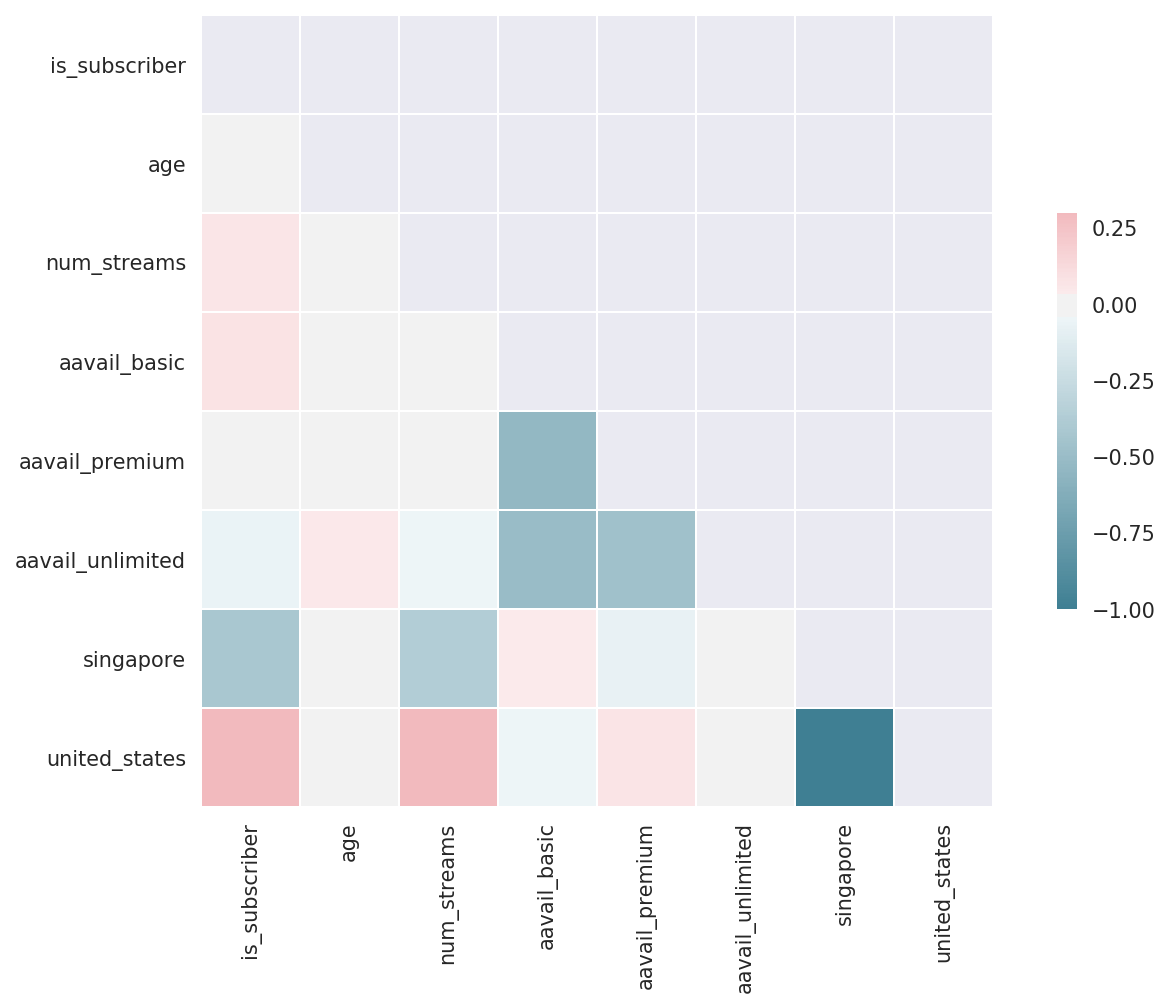

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline

def make_corr_plot(df, columns):
    """
    make a pairwise correlation plot
    """
    
    # Compute the correlation matrix
    corr = df[columns].corr()
    
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 7), dpi=150, facecolor="white")
    
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, 
                square=True, linewidths=.5, cbar_kws={"shrink":.5})
    
make_corr_plot(df1, labels)

### Use LogisticRegression to impute the missing values

In [8]:
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

## variables
impute_col = 0
C = 0.01

## identify the values that can be used as features
y_impute = X[:, impute_col].copy()
X_impute = X[:, np.setdiff1d(np.arange(X.shape[1]), impute_col)].copy()
missing = np.isnan(y_impute)

## scale using sklearn
scaler = preprocessing.StandardScaler().fit(X_impute)
X_impute = scaler.transform(X_impute)

mod1 = LogisticRegression(C=C, solver="lbfgs")
mod1.fit(X_impute[~missing], y_impute[~missing])
predicted_missing = mod1.predict(X_impute[missing])
print(classification_report(known_missing, predicted_missing, target_names=["inactive", "subscriber"]))

X1 = X.copy()
X1[missing, impute_col] = predicted_missing

              precision    recall  f1-score   support

    inactive       0.43      0.19      0.26        16
  subscriber       0.70      0.88      0.78        34

   micro avg       0.66      0.66      0.66        50
   macro avg       0.56      0.53      0.52        50
weighted avg       0.61      0.66      0.61        50



In [9]:
datasets = []
for C in [0.01, 0.1, 0.5]:
    mod1 = LogisticRegression(C=C, solver="lbfgs")
    mod1.fit(X_impute[~missing], y_impute[~missing])
    predicted_missing = mod1.predict(X_impute[missing])
    print(classification_report(known_missing, predicted_missing, target_names=["inactive", "subscriber"]))
    
    X_new = X.copy()
    X_new[missing, impute_col] = predicted_missing
    datasets.append(X_new)

              precision    recall  f1-score   support

    inactive       0.43      0.19      0.26        16
  subscriber       0.70      0.88      0.78        34

   micro avg       0.66      0.66      0.66        50
   macro avg       0.56      0.53      0.52        50
weighted avg       0.61      0.66      0.61        50

              precision    recall  f1-score   support

    inactive       0.33      0.25      0.29        16
  subscriber       0.68      0.76      0.72        34

   micro avg       0.60      0.60      0.60        50
   macro avg       0.51      0.51      0.50        50
weighted avg       0.57      0.60      0.58        50

              precision    recall  f1-score   support

    inactive       0.33      0.25      0.29        16
  subscriber       0.68      0.76      0.72        34

   micro avg       0.60      0.60      0.60        50
   macro avg       0.51      0.51      0.50        50
weighted avg       0.57      0.60      0.58        50

